## Set up the working environment for tensorflow
This section does not need to be edited.

In [1]:
from IPython.display import Image
import tensorflow as tf
from tensorflow.keras import Model, utils
from tensorflow.keras.layers import Dense, Flatten, Conv2D
from tensorflow.keras import preprocessing as pre
from functools import partial
import matplotlib.pyplot as plt
import numpy as np
import time
import os

In [2]:
def config_gpu():
    #Configure Gpus
    gpus = tf.config.experimental.list_physical_devices('GPU')
    if gpus:
        try:
            # Currently, memory growth needs to be the same across GPUs
            for gpu in gpus:
                tf.config.experimental.set_memory_growth(gpu, True)
            logical_gpus = tf.config.experimental.list_logical_devices('GPU')
            print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
        except RuntimeError as e:
            # Memory growth must be set before GPUs have been initialized
            print(e)

In [3]:
config_gpu()

1 Physical GPUs, 1 Logical GPUs


## Checkpoint 1: Define Training/Test data size and dimension. Explain the rationale for your selection.

In [4]:
test_size = 0.25 # implies that train_size = 0.75

The dataset consists of 10,000 images which is a sizeable amount. Based on online searches, 75-25 train-test split is commonly used. I do not want to set a higher ratio for test set because it means longer training time and less test images for validation. Setting `test_size = 0.25` is reasonable.

In [8]:
# Preprocessing Images Functions

label_dict = {'CNV': 0, 'DME': 1, 'DRUNSEN': 2, 'NORMAL': 3}

def label2idx(label):
    return label_dict[label]

def process_path(file_path):
    img_data = tf.io.read_file(file_path)
    label = tf.strings.split(file_path, os.sep)[-2]
    return tf.image.decode_jpeg(img_data), label

def extract_xy(image_raw, label):
    x = tf.squeeze(image_raw) # all images are gray and have dim=1 at axis=2, so we can remove this
    y = label2idx(label.numpy().decode('ascii')) # tf.string are encoded as binary string, so we need to convert
    return x, y

def normalize(img):
    return (img - np.min(img)) / (np.max(img) - np.min(img))

In [9]:
# Create a tensorflow pipeline - https://www.tensorflow.org/guide/data

list_ds = tf.data.Dataset.list_files('Data/*/*')

# The files in each class directory are examples, list 5 of them
for f in list_ds.take(5):
    print(f.numpy().decode('ascii'))

Data\DRUNSEN\DRUSEN-995513-16.jpeg
Data\NORMAL\NORMAL-9251-5.jpeg
Data\DME\DME-3114569-7.jpeg
Data\DME\DME-3340309-19.jpeg
Data\DME\DME-3278210-1.jpeg


In [10]:
labeled_ds = list_ds.map(process_path)
# print(len(list(labeled_ds)))

## Checkpoint 2: Print a sample of the data. Explain the selected range and the purpose of normalisation.

x is: [[0.         0.01176471 0.         ... 0.         0.01960784 0.        ]
 [0.         0.01176471 0.         ... 0.         0.01176471 0.        ]
 [0.00392157 0.01176471 0.         ... 0.         0.         0.01960784]
 ...
 [0.00784314 0.01960784 0.01960784 ... 0.         0.         0.        ]
 [0.         0.01960784 0.01960784 ... 0.         0.         0.00392157]
 [0.         0.00392157 0.00784314 ... 0.         0.         0.00784314]]
y is: 0


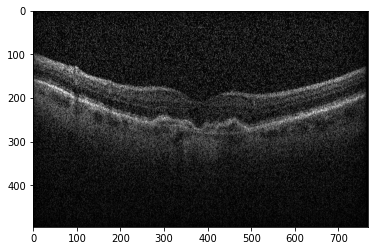

In [11]:
# check one of the labeled x, y
for image_raw, label in labeled_ds.take(1):
    x, y = extract_xy(image_raw, label)
    x_norm = normalize(x)
    print("x is: {}".format(x_norm))
    print("y is: {}".format(y))
    plt.imshow(x_norm, cmap='gray')

Normalization is a process that changes the range of pixel intensity values. The numpy array of the image will be normalized with maximum as the highest pixel intensity value (usually 255), and minimum as the lowest pixel value (usually 0). This will help improve the contrast of the image.

## Checkpoint 3: Display the graph. Print out of the model.

In [12]:
# Build Base Model (As defined in the exercise)

class MyModel(Model):
    def __init__(self):
        super(MyModel, self).__init__()
        self.conv1 = tf.keras.layers.Conv2D(32, 3, padding='same', activation='relu')
        self.pool = tf.keras.layers.MaxPooling2D(pool_size=(2, 2), strides=2, padding='same')
        self.flatten = tf.keras.layers.Flatten()
        self.d1 = tf.keras.layers.Dense(256, activation='relu')
        self.d2 = tf.keras.layers.Dense(128, activation='relu')
        self.d3 = tf.keras.layers.Dense(4, activation='softmax') # 4 classes: CNV, DME, DRUNSEN, NORMAL

    def call(self, x):
        x = self.conv1(x)
        x = self.pool(x)
        x = self.flatten(x)
        x = self.d1(x)
        x = self.d2(x)
        x = self.d3(x)
        return x

In [13]:
# Create an instance of the model

model = MyModel()
utils.plot_model(model, to_file='model.png')

InvocationException: GraphViz's executables not found

## Checkpoint 4: Explain selection of loss function and optimiser Optimizer 

In [14]:
# Define Loss function and Optimiser

loss_object = tf.keras.losses.SparseCategoricalCrossentropy()
optimizer = tf.keras.optimizers.Adam()

I use SparseCategoricalCrossentropy loss function because there are two or more label classes, and I will be encoding the labels as integers (as opposed to using CategoricalCrossEntropy using one-hot representation).

I use Adam becuase it combines the good properties of Adadelta and RMSprop and hence tend to do better for most of the problems. Choosing Adam sounds like a reasonable approach to begin with.

In [ ]:
#Define Training/Testing Function here

In [ ]:
#Checkpoint 5: Display training loss-epoch graph


In [ ]:
#Checkpoint 6: Display Accuracy-epoch graph

In [ ]:
#Checkpoint 7: Define and explain the choice of transfer base model for transfer learning

In [ ]:
#Checkpoint 8: Display graph printout of the base model with the OCT image classication extension

In [ ]:
#Checkpoint 9: The training data currently being used is simple and as such transfer learning isn't as advantageous,
#however some observations can be made when comparing the first model with the second, discuss these observation.

In [ ]:
#Checkpoint 10: Discuss why this may not be favourable and the problems it presents. 


In [ ]:
#Checkpoint 11: Show some methods that can be utilised to negate or minimise these effects. 
#Compare the accuracy and explain the pros and cons of these techniques (If any) 